In [1]:
### analysis
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from gsw import SA_from_SP, CT_from_pt, sigma0
from scipy.stats import linregress

### plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
# import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams

# rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=29) 
rc('ytick', labelsize=29) 
rc('axes', labelsize=29)
from matplotlib.ticker import MultipleLocator

#### This notebook complements Supporting Information section 2. It outlines how we derive the $\alpha$ parameter and timeseries and climatologies of $F_\mathrm{surf}$ and $\Psi_\mathrm{in}$ from WAIS 1080 output. 

author: Ruth Moorman, May 2023, rmoorman@caltech.edu


# S2.1 Diagnosing the $\alpha$ parameter from WAIS 1080

In our idealized model, $\alpha$ is defined such that,
$$\frac{1}{\text{ice front width}}\int_A F_\mathrm{ice shelf} \, dA  = \alpha\,h_\mathrm{mCDW}\,\Delta b_\mathrm{melt}$$
is the total buoyancy input to the ocean from ice shelf melt. This can be extracted from (14) in the main text.

Therefore, to derive an estimate for the parameter $\alpha$, we need to compute the integrated $F_\mathrm{ice shelf}$ (total buoyancy input from the ice shelf) and $h_\mathrm{mCDW}$ (thickness of the ice front mCDW layer) from WAIS 1080 output. The variable $\Delta b_\mathrm{melt}$ is taken to be $6.7\times10^{-3}$ m s$^{-2}$ as described in the main text.

### Step 1: Diagnosing $F_\mathrm{ice shelf}$

$F_\mathrm{ice shelf}$ is defined functionally as (positive values increase the ocean buoyancy),

$$F_\mathrm{iceshelf}\equiv B\equiv B_H+B_{FW} \equiv \frac{g \alpha}{\rho_\text{surf}c_p}Q_H - g \beta S_\text{surf} Q_{FW}$$

where,

• $g=9.8$ m s$^{-2}$ (gravity)

• $\alpha = $ thermal expansion coefficient 

• $\beta = $ haline contraction coefficient 

• $c_p = 3992$ J kg$^{-1}$ K$^{-1}$ (specific heat capacity of seawater)

• $\rho_\text{surf} = $ surface cell density (assumed 1026)

• $S_\text{surf} = $ surface cell salinity (assumed 34)

• $Q_H = $ net heat flux from the ice (positive increases $\theta$) (model output)

• $Q_{FW} = $ net freshwater flux from the ice (positive increases $S$) (model output)


```
### note - these model output files were too large for GitHub storage (>100 MB) so here is the processing - processed files are infiled later for plotting purposes
## load data
state_2d_shi  = xr.open_dataset('WAIS1080-state_2d_shi-trimmed.nc')
QH_shi        = state_2d_shi.SHIhtFlx # defined positive upwards, so minus this required (next cell)
QFW_shi       = state_2d_shi.SHIfwFlx # defined positive upwards, so minus this required
iceshelf_mask = QH_shi.draft*0+1
QH_shi        = QH_shi*iceshelf_mask
QFW_shi       = QFW_shi*iceshelf_mask
ocean_mask    = QH_shi.maskInC.where(QH_shi.maskInC==1).where(iceshelf_mask!=1)

## compute F_iceshelf
g    = 9.8 #m/s2
α    = 4.8 * 1e-5 #/K
β    = 7.8 * 1e-4 #unitless
c_p  = 3991.87 #J/kg/K
S_0  = 34 #g/kg
ρ_0  = 1026 #kg/m3
B_H_shi     = -g*α*1/c_p*1/ρ_0*QH_shi
B_FW_shi    = -g*β*S_0*QFW_shi/ρ_0
F_ice_shelf = B_H_shi + B_FW_shi
## save time mean value for maps
Ficeshelf_timemean = F_ice_shelf.mean('time') ## for plotting
ds = xr.Dataset({'Ficeshelf':Ficeshelf_timemean})
ds.to_netcdf('Ficeshelf_map.nc')

## calculate timeseries (using geographic bounds mapped below)
W=-114.5;E=-111.5;S=-75.3;N=-74.13
# create a mask from these bounds
DIS_mask  = iceshelf_mask.where(iceshelf_mask.LATC<N); DIS_mask  = DIS_mask.where(DIS_mask.LONC<E); DIS_mask  = DIS_mask.where(DIS_mask.LONC>W)
# apply to the Ficeshelf array and cell area arrays
F_iceshelf_DIS = F_ice_shelf    * DIS_mask
rA_DIS         = F_ice_shelf.rA * DIS_mask
# spatial integration
ice_shelf_width = 55 * 1e3 # this is the zonal extent of ice shelf in WAIS 1080
F_iceshelf_int  = (F_iceshelf_DIS*rA_DIS).sum(['XC','YC'])/ice_shelf_width
F_iceshelf_int  = F_iceshelf_int.load()
## save timeseries
ds = xr.Dataset({'Ficeshelf':F_iceshelf_int})
ds.to_netcdf('Ficeshelf_timeseries.nc')
````

In [2]:
Ficeshelf_timemean = xr.open_dataset('Ficeshelf_map.nc').Ficeshelf
Ficeshelf_timeseries = xr.open_dataset('Ficeshelf_timeseries.nc').Ficeshelf
iceshelf_mask = Ficeshelf_timemean.draft*0+1
ocean_mask    = Ficeshelf_timemean.maskInC.where(Ficeshelf_timemean.maskInC==1).where(iceshelf_mask!=1)


In [3]:
## a couple of plotting functions
def model_grid_map_features(ax, ds, iceshelf_mask=iceshelf_mask):
    ax.contourf(ds.LONC,ds.LATC,ds.maskInC.where(ds.maskInC==0), colors=['darkgrey'])
    ax.contour(ds.LONC,ds.LATC,ds.maskInC.where(ds.maskInC==0).fillna(1),levels=[-1,0,1], colors=['black'], linewidths=1)
    ax.set_ylabel(r'$\mathrm{Latitude}\; (^\circ\mathrm{N})$')
    ax.set_xlabel(r'$\mathrm{Longitude}\; (^\circ\mathrm{E})$')
    ax.contour(ds.LONC, ds.LATC,-ds.bathy*ocean_mask, levels = [500,1000,4000], colors=['grey'], linewidths=0.6)
    ax.contour(ds.LONC, ds.LATC,iceshelf_mask.fillna(0), levels = [0,1], colors=['k'], linewidths=0.6)
def box(ax,W,E,S,N,color):
    ax.plot([W,W],[S,N], color=color, linewidth=2, linestyle='dashed')
    ax.plot([E,E],[S,N], color=color, linewidth=2, linestyle='dashed')
    ax.plot([W,E],[N,N], color=color, linewidth=2, linestyle='dashed')
    ax.plot([W,E],[S,S], color=color, linewidth=2, linestyle='dashed')
def model_grid_map_features_grid(ax, ds, iceshelf_mask=iceshelf_mask):
    ax.contourf(ds.maskInC.where(ds.maskInC==0), colors=['darkgrey'])
    ax.contour(ds.maskInC.where(ds.maskInC==0).fillna(1),levels=[-1,0,1], colors=['black'], linewidths=1)
    ax.contour(-ds.bathy*ocean_mask, levels = [500,1000,4000], colors=['grey'], linewidths=0.6)
    ax.contour(iceshelf_mask.fillna(0), levels = [0,1], colors=['k'], linewidths=0.6)
    ax.set_xlabel('XC (model grid)')
    ax.set_ylabel('YC (model grid)')
    

Below is the box over which $F_\mathrm{iceshelf}$ is integrated. Whilst the Dotson and Crosson ice shelves appear continuous there is a bathymetric boundary such that very little exchange is simulated across 111.5$^\circ$W.

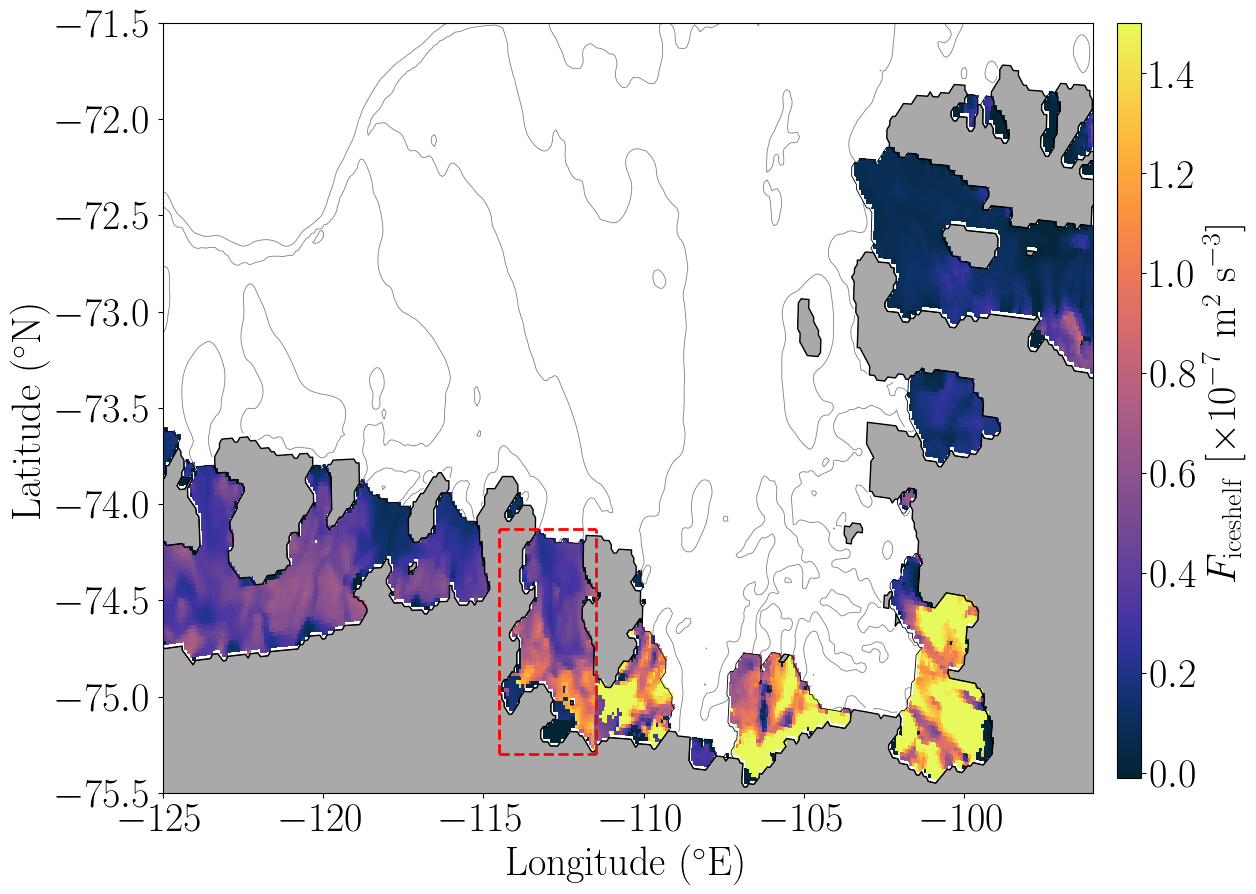

In [4]:
## map of time mean Ficeshelf alongside chosen boundaries for Ficeshelf timeseries
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
model_grid_map_features(ax, Ficeshelf_timemean)
c = ax.pcolormesh(Ficeshelf_timemean.LONC, Ficeshelf_timemean.LATC,Ficeshelf_timemean*1e7, cmap = cm.thermal, vmax=1.5)
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label(r'$F_\mathrm{ice shelf}$ [$\times 10^{-7}$ m$^{2}$ s$^{-3}$]')
W=-114.5;E=-111.5;S=-75.3;N=-74.13
box(ax,W,E,S,N,'r')
ax.set_xlim([-125,-96])
ax.set_ylim([-75.5,-71.5])
plt.show()

### Step 2: Diagnosing $h_\mathrm{mCDW}$

In [5]:
# the following netcdf contains spatially averaged (over the same region used for Fsurf and Psiin calculations) tracers from the ice shelf front, here we just need temperature for the thermocline
theta = xr.open_dataset('WAIS1080_DIS_front_hovmollers.nc').THETA

# for this purpose it's simple to define the thermocline as the 0C isotherm
isotherm_0C_timeseries = xr.DataArray(np.zeros(len(theta.time)), coords = [theta.time], dims=['time'], attrs=[{'(spatially averaged) depth of the 0C isotherm (below 200m) at the DIS front from monthly output [m]', 'description'}])
for i in range(len(isotherm_0C_timeseries)):
    column_temp = theta.sel(Z = slice(-200,-1000)).isel(time=i) # trim surface
    isotherm_0C_timeseries[i]=np.interp(0,column_temp,column_temp.Z)

# we'll need the mean depth to convert isotherm depth (h) to cdw thickness (hcdw)
H=786
h_WAIS1080 = -isotherm_0C_timeseries
hmCDW_WAIS1080 = H+isotherm_0C_timeseries 

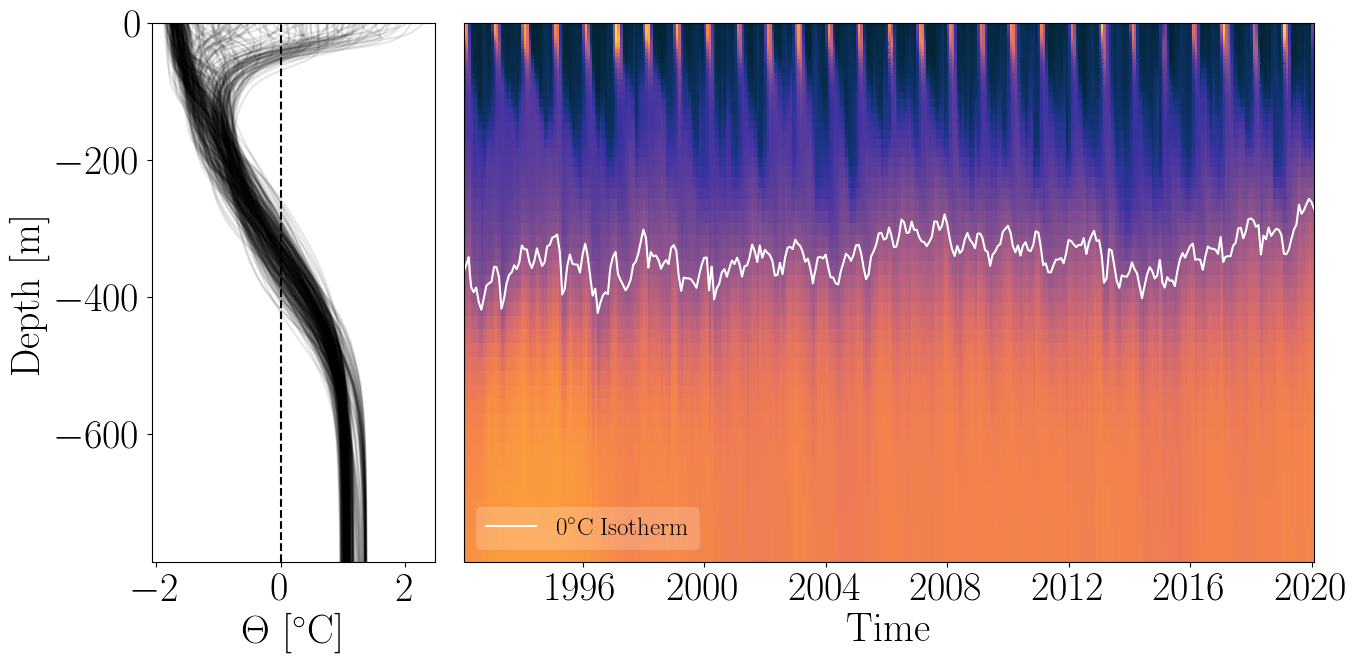

In [6]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(15,7), gridspec_kw={'width_ratios': [1, 3], 'wspace':0.05})
ax.plot(theta.T,theta.Z, 'k',alpha=0.1)
ax.set_ylim([-H,0]); ax.axvline(0,color='k',linestyle='dashed')
ax.set_xlabel(r'$\Theta$ [$^\circ$C]'); ax.set_ylabel('Depth [m]')
c = ax1.pcolormesh(theta.time, theta.Z, theta.T, vmin=-1.8, vmax=2.3, cmap=cm.thermal)
ax1.set_ylim([-H,0]);ax1.set_yticks([]); ax1.set_xlabel('Time')
ax1.contour(theta.sel(Z=slice(-200,-1000)).time, theta.sel(Z=slice(-200,-1000)).Z, theta.sel(Z=slice(-200,-1000)).T, levels=[0], colors='white')
# ax.axhline(-H, color='white', linestyle='dashed', label=r'$\mathrm{Mean}\;\mathrm{Column}\; \mathrm{Thickness}$')
ax1.axhline(H, color='white', label=r'$0^\circ\mathrm{C}\;\mathrm{Isotherm}$')
ax1.legend(loc=3,fontsize=18,framealpha=0.2)
plt.show()

One can clearly see that the ice front thermocline is much less variable than in the observations, something we explore in the main text.

### Step 3: Diagnosing $\alpha$

Below the dashed line is a linear fit and the solid line is an approximation enforcing zero intercept.

Data points in blue are removed from the analysis as it seems to take some time for the relation to stabilize (next plot).

In [8]:
bmelt = 6.7*1e-3

print(np.mean(Ficeshelf_timeseries.sel(time=slice('1995',None))/(hmCDW_WAIS1080.sel(time=slice('1995',None))*bmelt)).values)
print(np.std(Ficeshelf_timeseries.sel(time=slice('1995',None))/(hmCDW_WAIS1080.sel(time=slice('1995',None))*bmelt)).values)

0.0021057750182881117
0.00015552454135298177


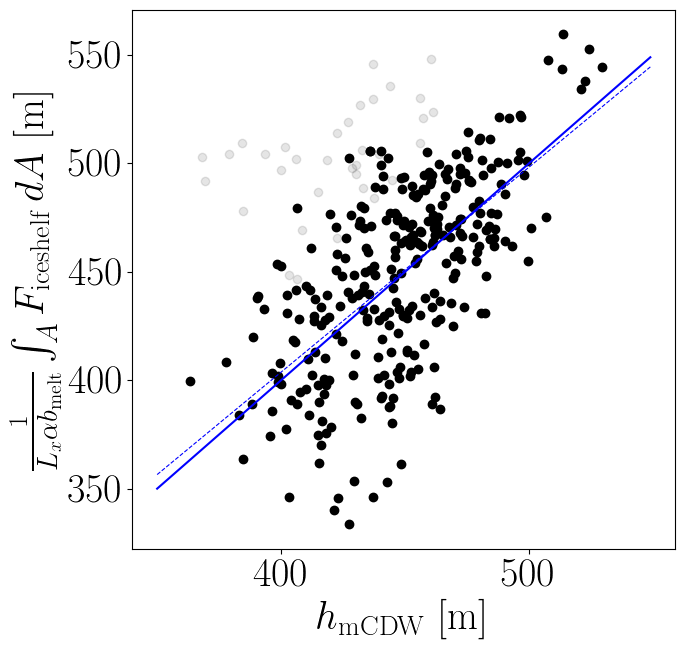

In [9]:
bmelt = 6.7*1e-3
α     = 0.0021
hmCDW_predicted = Ficeshelf_timeseries/(α*bmelt)

fig, (ax) = plt.subplots(1,1, figsize=(7,7))
ax.scatter(hmCDW_WAIS1080,hmCDW_predicted, alpha=0.1, color='k')
ax.scatter(hmCDW_WAIS1080.sel(time=slice('1995',None)),hmCDW_predicted.sel(time=slice('1995',None)), color='k') # first few years have a consistent bias, likely a spin up things
ax.plot(np.arange(350,550),np.arange(350,550), 'b') # simplified linear relation with zero intercept
slope,intercept,_,_,_ = linregress(hmCDW_WAIS1080.sel(time=slice('1995',None)),hmCDW_predicted.sel(time=slice('1995',None)))
ax.plot(np.arange(350,550),slope*np.arange(350,550)+intercept,'b--', linewidth=0.8) # actual linear best fit
ax.set_xlabel(r'$h_\mathrm{mCDW}$ [m]')
ax.set_ylabel(r'$\frac{1}{L_x\alpha b_\mathrm{melt}}\int_A F_\mathrm{iceshelf}\, dA$ [m]')
plt.show()

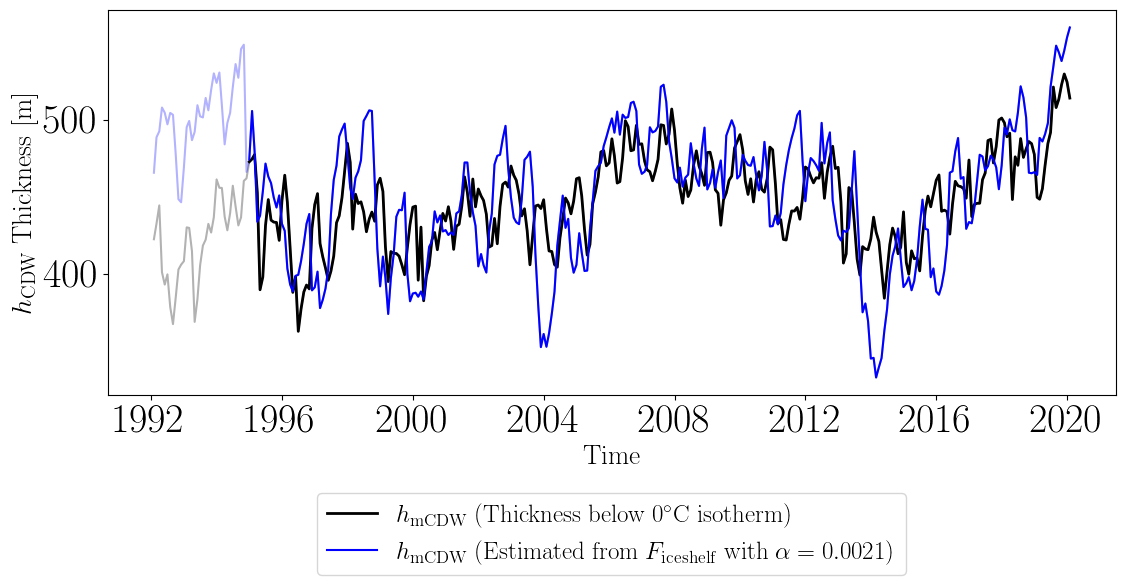

In [10]:
fig, ax1 = plt.subplots(1,1, figsize=(13,5))
cbar.set_label(r'$\Theta \; [^\circ\mathrm{C}]$', fontsize = 20)
# isotherm depth
ax1.set_xlabel(r'$\mathrm{Time}$', fontsize=20)
ax1.set_ylabel(r'$h_\mathrm{CDW}\;\mathrm{Thickness}\; [\mathrm{m}]$', fontsize=20)
ax1.plot(isotherm_0C_timeseries.time,hmCDW_WAIS1080, 'k', alpha=0.3)
ax1.plot(isotherm_0C_timeseries.time,hmCDW_predicted, 'b', alpha=0.3)
ln1 = ax1.plot(isotherm_0C_timeseries.sel(time=slice('1995',None)).time,hmCDW_WAIS1080.sel(time=slice('1995',None)), 'k', linewidth=2,label=r'$h_\mathrm{mCDW}\;(\mathrm{Thickness}\;\mathrm{below}\;0^\circ\mathrm{C}\;\mathrm{isotherm})$')
ln2 = ax1.plot(isotherm_0C_timeseries.sel(time=slice('1995',None)).time,hmCDW_predicted.sel(time=slice('1995',None)), 'b',label=r'$h_\mathrm{mCDW}\;(\mathrm{Estimated}\;\mathrm{from}\;F_\mathrm{iceshelf}\;\mathrm{with}\;\alpha=0.0021$)')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc='lower center', bbox_to_anchor=(0.5, -0.5),fontsize=18)
plt.show()



# S2.2 Diagnosing $F_\mathrm{surf}$ from WAIS 1080

$F_\mathrm{surf}$ is defined functionally as (positive values increase the buoyancy of the surface cell),

$$F_\text{surf}\equiv B\equiv B_H+B_{FW} \equiv \frac{g \alpha}{\rho_\text{surf}c_p}Q_H - g \beta S_\text{surf} Q_{FW}$$

where,

• $g=9.8$ m s$^{-2}$ (gravity)

• $\alpha = $ thermal expansion coefficient 

• $\beta = $ haline contraction coefficient 

• $c_p = 4190$ J kg$^{-1}$ K$^{-1}$ (specific heat capacity of seawater)

• $\rho_\text{surf} = $ surface cell density (assumed 1026)

• $S_\text{surf} = $ surface cell salinity (assumed 34)

• $Q_H = $ net surface heat flux (positive increases $\theta$) (diagnosed)

• $Q_{FW} = $ net surface freshwater flux (positive increases $S$) (diagnosed)


Now once again we need to select a region to compute this metric for, we choose a small region at the ice fron where negative buoyancy fluxes are concentrated.

```
### again - these model output files were too large for GitHub storage (>100 MB) so here is the processing - processed files are infiled later for plotting purposes

## load data
state_2d_oce  = xr.open_dataset('WAIS1080-state_2d_oce-trimmed.nc')
rho_surf      = xr.open_dataset('WAIS1080-rhosurf-trimmed.nc')
QH            = state_2d_oce.oceQnet
QFW           = state_2d_oce.oceFWflx
iceshelf_mask = QH.draft*0+1
ocean_mask    = QH.maskInC.where(QH.maskInC==1).where(iceshelf_mask!=1)
QH_oce        = QH*ocean_mask
QFW_oce       = QFW*ocean_mask

## compute Fsurf
g    = 9.8 #m/s2
α    = 4.8 * 1e-5 #/K
β    = 7.8 * 1e-4 #unitless
c_p  = 3991.87 #J/kg/K
ρ_FW = 1000 #kg/m3
S_0  = 34 #g/kg
ρ_0  = 1026 #kg/m3

B_H_surf    = g*α*1/c_p*1/ρ_0*QH_oce
B_FW_surf   = g*β*S_0*QFW_oce/ρ_FW
F_surf = B_H_surf + B_FW_surf
## save time mean value for maps
Fsurf_timemean = F_surf.mean('time') ## for plotting
ds = xr.Dataset({'Fsurf':Fsurf_timemean})
ds.to_netcdf('Fsurf_map.nc')

## calculate timeseries (using geographic bounds mapped below)
W=-113.45;E=-111.5;S=-74.26;N=-73.9
DIS_front_mask  = ocean_mask.where(ocean_mask.LATC<N)
DIS_front_mask  = DIS_front_mask.where(DIS_front_mask.LONC<E)
DIS_front_mask  = DIS_front_mask.where(DIS_front_mask.LONC>W)
Fsurf_DIS_front = F_surf    * DIS_front_mask
rA_DIS_front    = F_surf.rA * DIS_front_mask
# area weighted mean
F_surf_timeseries = (Fsurf_DIS_front*rA_DIS_front).mean(['XC','YC'])/rA_DIS_front.mean(['XC','YC'])
F_surf_timeseries = F_surf_timeseries.load()
# F_surf_climatology = F_surf_timeseries.groupby('time.month').mean()
## save timeseries
ds = xr.Dataset({'Fsurf':F_surf_timeseries})
ds.to_netcdf('Fsurf_timeseries.nc')
```

In [11]:
Fsurf_timemean = xr.open_dataset('Fsurf_map.nc').Fsurf
Fsurf_timeseries = xr.open_dataset('Fsurf_timeseries.nc').Fsurf
iceshelf_mask = Fsurf_timemean.draft*0+1
ocean_mask    = Fsurf_timemean.maskInC.where(Fsurf_timemean.maskInC==1).where(iceshelf_mask!=1)
Fsurf_climatology = Fsurf_timeseries.groupby('time.month').mean()

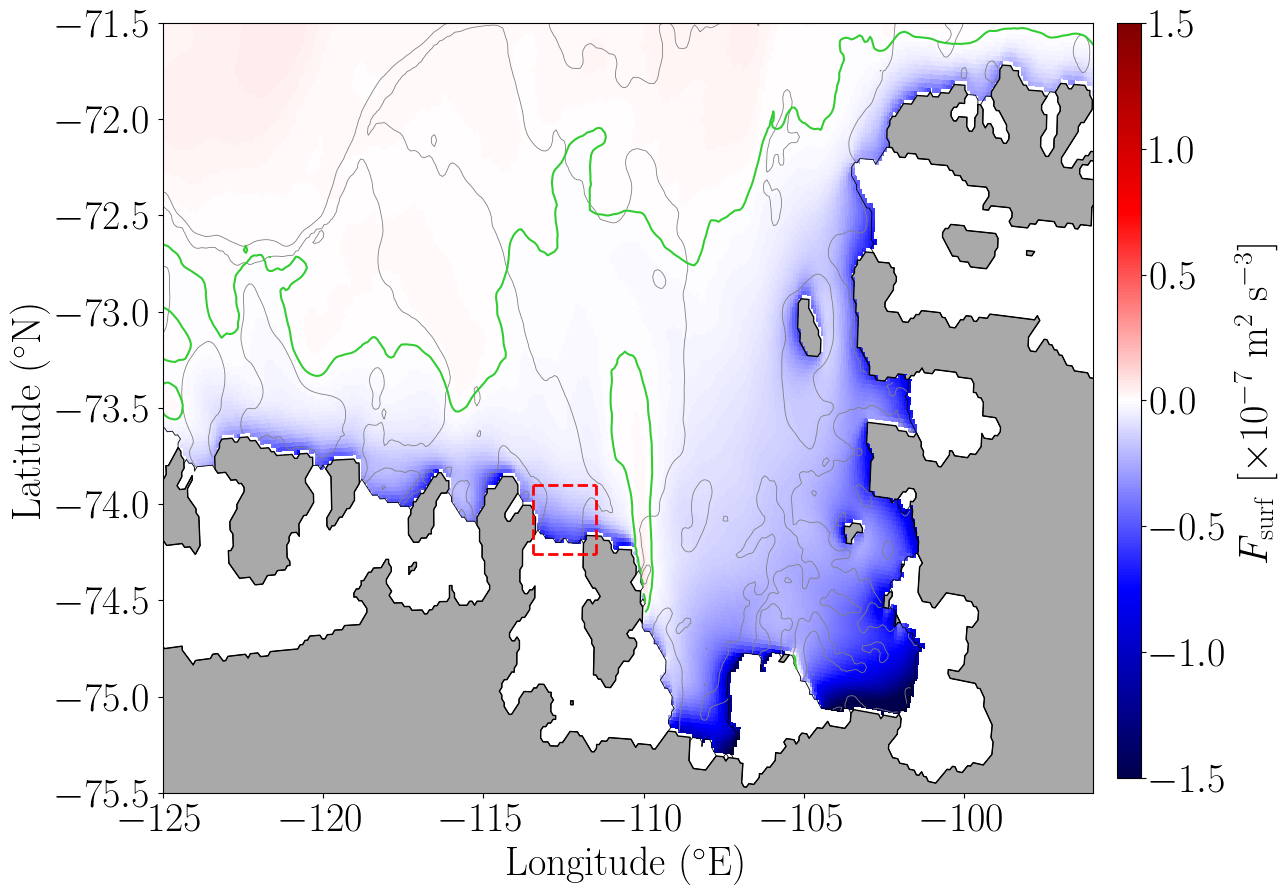

In [12]:
## map of time mean Ficeshelf alongside chosen boundaries for Ficeshelf timeseries
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
model_grid_map_features(ax, Fsurf_timemean)
c = ax.pcolormesh(Fsurf_timemean.LONC, Fsurf_timemean.LATC,Fsurf_timemean*1e7, cmap = 'seismic', vmin=-1.5,vmax=1.5)#, vmin=-300, vmax=300)
ax.contour(Fsurf_timemean.LONC, Fsurf_timemean.LATC,Fsurf_timemean, levels=[0], colors='limegreen')#, vmin=-300, vmax=300)
cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label(r'$F_\mathrm{surf}$ [$\times 10^{-7}$ m$^{2}$ s$^{-3}$]')
W=-113.45;E=-111.5;S=-74.26;N=-73.9
box(ax,W,E,S,N,'r');
ax.set_xlim([-125,-96])
ax.set_ylim([-75.5,-71.5])

plt.show()

In [13]:
Fsurf_climatology_expanded = xr.zeros_like(Fsurf_timeseries)
for i in range(len(Fsurf_timeseries)):
    month = Fsurf_timeseries['time.month'][i].values
    Fsurf_climatology_expanded[i] = Fsurf_climatology.sel(month=month)

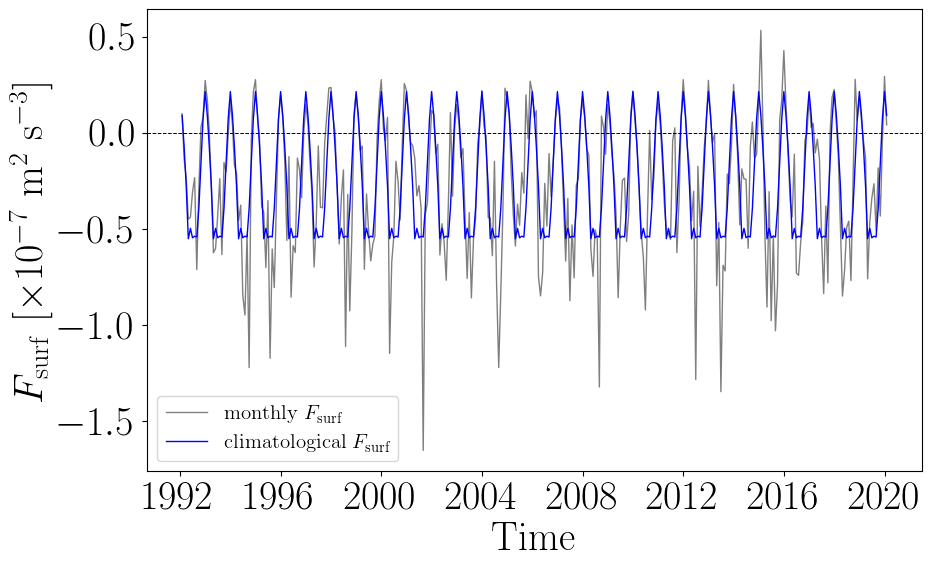

In [14]:
fig = plt.figure(figsize = (10,6))
ax = plt.subplot()
ax.plot(Fsurf_timeseries.time,Fsurf_timeseries*1e7, color='k', linewidth=1, alpha=0.5,label='monthly $F_\mathrm{surf}$')
ax.plot(Fsurf_timeseries.time,Fsurf_climatology_expanded*1e7, color='b', linewidth=1,label='climatological $F_\mathrm{surf}$')
ax.set_xlabel('Time')
ax.axhline(0, color='k',linestyle='dashed',linewidth=0.7)
ax.set_ylabel(r'$F_\mathrm{surf}$ [$\times 10^{-7}$ m$^2$ s$^{-3}$]')
ax.legend(loc=0, fontsize=15)
# plt.savefig('Figure_S2-2.png', bbox_inches='tight')

plt.show()

In [15]:
## some basic statistics
print(Fsurf_timeseries.mean().values, Fsurf_timeseries.min().values, Fsurf_timeseries.max().values)


-2.650803424903477e-08 -1.6506006161017006e-07 5.3327103380551477e-08


### comparing $F_\mathrm{surf}$ to observational estimates of annual ASP ice formation (from MacDonald et al 2023)

We can estimate annual mean values of $Q_H$ (units: J m$^{-2}$ s$^{-1}$) and $Q_{FW}$ (units: m s$^{-1}$) from observations estimates of the mass (kg) of ice produced by the ASP per year.

$$Q_H \approx \frac{m_\mathrm{ice} \, L_f}{A}$$

where $m_\mathrm{ice} = M_\mathrm{ice}/(3.154 \times 10^{7} \mathrm{s}\,\mathrm{yr}^{-1})$ is the mean mass of ice formed per second in the ASP (in g) and $M_\mathrm{ice}$ is the mass of ice formed per year (in g). $L_f$ is the latent heat of fusion (334 J g$^{-1}$) and $A$ is the polynya area (m$^2$). *Note this is only the heat from fusion of ice and not the net heat flux, bit of an issue there...*

In [34]:
ρice   = 0.917*1e15 #convert from g/cm^3 to g/km^3
M_ice  = np.array([139,121,95,80]) * ρice # units is km^3 of ice initially, convert to g of ice
polynya_area  = np.array([10908,9963,8152,6910])*1e6 # covert km^2 to m^2
m_ice  = M_ice*3.154*1e-7 # covert from g ice/yr to g ice/s
Lf     = 334 #J/g
QH_obs = - m_ice*Lf/polynya_area# units J m^(-2) s^(-1)

In [49]:
print(np.mean(M_ice/ρice))
print(np.std(M_ice/ρice))

108.75
22.807619340913245


In [36]:
V_ice = np.array([139,121,95,80]) * 1e9 # convert units from km3 to m3
h_ice = V_ice/polynya_area # units m ice (thickness) or similarly m freshwater (?)
Q_FW_obs = h_ice*3.154*1e-7 # covert from m ice/yr to m ice/s

In [39]:
g    = 9.8 #m/s2
α    = 4.8 * 1e-5 #/K
β    = 7.8 * 1e-4 #unitless
c_p  = 3991.87 #J/kg/K
ρ_surf = 1000 #kg/m3
S_surf = 34

Fsurf_obs = g*α/(ρ_surf*c_p)*QH_obs - g*β*S_surf*Q_FW_obs

In [40]:
Fsurf_obs

array([-1.18961094e-06, -1.13378451e-06, -1.08791437e-06, -1.08080468e-06])

So this is obviously waaay larger magnitude than what I'm getting from WAIS 1080 but I think that's because I'm only taking into account buoyancy loss from sea-ice formation not net curface buoyancy exchange.

## Deriving $\Psi_\mathrm{in}$ from WAIS1080

The basic procedure I have used to derive $\Psi_\mathrm{in}$ is as follows. I use monthly model output to compute mass transports into the study regions binned by potential density. This is computed both along the northern, eastern, and western boundaries of the domain. These are then cummulatively summed in density space and combined to capture the full exchange of inflowing denser waters and outflowing lighter waters occuring in the region. In the same procedure I extract mean temperature on these density bins and later use that information to determine the tranport of waters below the (deeper, where a surface isotherm exists) 0$^\circ$ C isotherm into the study region. This is our $\Psi_\mathrm{in}$.



It was slightly easier to compute these values on the model grid rather than on a latitude and longtiude grid, suitable model grid box bounds comparable to the latitude/longitude grid box above are found below.

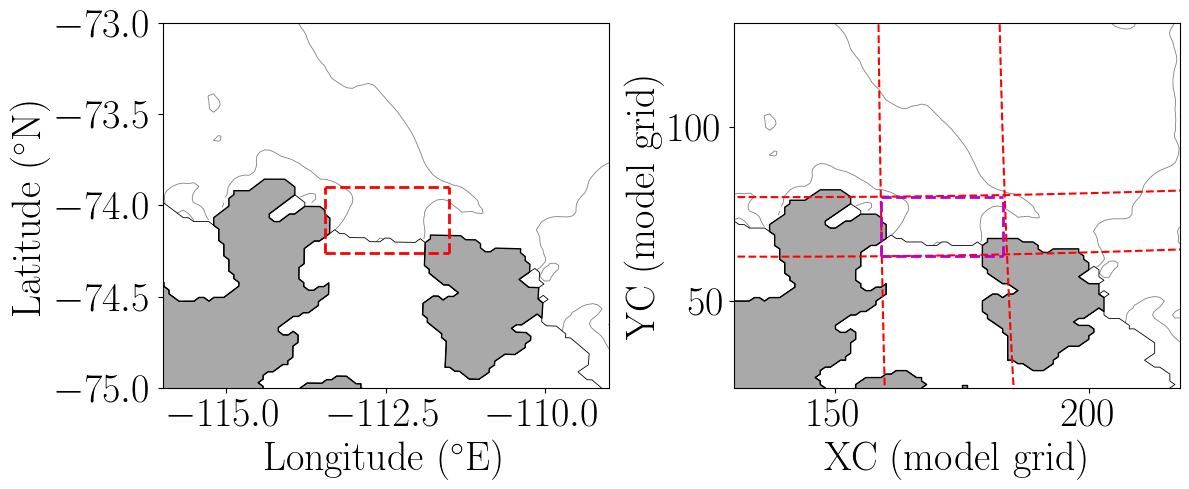

In [14]:
fig = plt.figure(figsize = (12,5))
gs = gridspec.GridSpec(ncols=2, nrows=1)
ax,ax1 = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

model_grid_map_features(ax, Fsurf_timemean)
W=-113.45;E=-111.5;S=-74.26;N=-73.9
box(ax,W,E,S,N,'r');
ax.set_xlim([-116,-109]);ax.set_ylim([-75,-73])

model_grid_map_features_grid(ax1, Fsurf_timemean)
lons = ax1.contour(Fsurf_timemean.LONC, levels=[W,E], colors=['r'])
lats = ax1.contour(Fsurf_timemean.LATC, levels=[S,N], colors=['r'])
W=159;E=183;S=63;N=80
box(ax1,W,E,S,N,'m');
ax1.set_xlim([130,218]);ax1.set_ylim([25,130])

fig.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
PAUSE IN INTERACTIVE CODE:
    
Due to the size of the required 3D model output, these next sections will not be interactive but are provided for reference.

</div>



```
import glob
from xmitgcm import open_mdsdataset

def open_WAIS_monthly_variables(subdir, prefix=None, start=None, end=None):
    # currently set up to work around the big where xmitgcm is dropping physical dimensions
    rootdir = '/export/data1/rmoorman/WAIS1080/'
    # make a list of the iteration numbers so one cal call a range like 0:2 rather than remembering the iteration number associated with the 0th and 1st saved timestep
    filenames = glob.glob(rootdir+'state_2d/state_2d_oce*.meta')
    iterations = np.zeros(len(filenames))
    for i in range(len(filenames)):
        iterations[i] = int(filenames[i][-15:-5])
    # open variable dataset for >1 iterations  
    if start !=None:
        ds = open_mdsdataset(rootdir+subdir,delta_t = 180, ref_date='1992-1-1 0:0:0',prefix=prefix, iters=iterations[start:end])      
    else:
        ds = open_mdsdataset(rootdir+subdir,delta_t = 180, ref_date='1992-1-1 0:0:0',prefix=prefix, iters='all')      
    # replace latitutde and longitude info with the correct version from binary files
    LONC = np.fromfile(rootdir+'grid/LONC.bin', dtype='>f4').reshape([600,1240]) # apparently needed big endian dtype, through me off a while 
    LATC = np.fromfile(rootdir+'grid/LATC.bin', dtype='>f4').reshape([600,1240])
    LONG = np.fromfile(rootdir+'grid/LONG.bin', dtype='>f4').reshape([600,1240]) 
    LATG = np.fromfile(rootdir+'grid/LATG.bin', dtype='>f4').reshape([600,1240])
    LONC = xr.DataArray(LONC, coords=[ds.YC,ds.XC], dims=['YC','XC'], attrs={'standard_name':'longitude', 'long_name':'LLC1080_geolon', 'units':'degrees_east'})
    LATC = xr.DataArray(LATC, coords=[ds.YC,ds.XC], dims=['YC','XC'], attrs={'standard_name':'latitude', 'long_name':'LLC1080_geolat', 'units':'degrees_north'})
    LONG = xr.DataArray(LONG, coords=[ds.YG,ds.XG], dims=['YG','XG'], attrs={'standard_name':'longitude', 'long_name':'LLC1080_geolon', 'units':'degrees_east'})
    LATG = xr.DataArray(LATG, coords=[ds.YG,ds.XG], dims=['YG','XG'], attrs={'standard_name':'latitude', 'long_name':'LLC1080_geolat', 'units':'degrees_north'})
    ds = ds.assign_coords({'LONC':LONC, 'LATC':LATC, 'LONG':LONG, 'LATG':LATG})
    # bathymetry information
    bathy = np.fromfile(rootdir+'grid/bathy_was1080_1240x600_v2.bin', dtype='>f4').reshape([600,1240])
    bathy = xr.DataArray(bathy, coords=[ds.YC,ds.XC], dims=['YC','XC'], attrs={'standard_name':'bathy', 'long_name':'bathymetry', 'units':'m'})
    bathy = bathy.where(ds.maskInC==1)
    ## ice draft (ocean only)
    draft = np.fromfile(rootdir+'grid/draft_was1080_1240x600_v2.bin', dtype='>f4').reshape([600,1240]) # apparently needed big endian dtype, through me off a while 
    draft = xr.DataArray(draft, coords=[ds.YC,ds.XC], dims=['YC','XC'], attrs={'standard_name':'draft', 'long_name':'ice_draft', 'units':'m'})
    oce_draft = draft.where(ds.maskInC==1).where(draft<0)
    ds = ds.assign_coords({'draft':oce_draft, 'bathy':bathy})
    
    return ds
```

```
# required variables for overturning circulation are THETA, SALTanom, Vvelmass, Uvelmass
THETA      = open_WAIS_monthly_variables('hydro/', prefix='THETA', start=None).THETA
SALT       = open_WAIS_monthly_variables('hydro/', prefix='SALTanom', start=None).SALTanom+35
VVELMASS   = open_WAIS_monthly_variables('hydro/', prefix='VVELMASS', start=None).VVELMASS
UVELMASS   = open_WAIS_monthly_variables('hydro/', prefix='UVELMASS', start=None).UVELMASS
```

```
THETA = THETA.isel(XC = slice(400,800), YC=slice(40,250))
SALT = SALT.isel(XC = slice(400,800), YC=slice(40,250))
VVELMASS = VVELMASS.isel(XC = slice(400,800), YG=slice(40,250))
UVELMASS = UVELMASS.isel(YC=slice(40,250),XG = slice(400,800))
THETA = THETA.where(THETA.maskC==True)
SALT = SALT.where(SALT.maskC==True)
VVELMASS = VVELMASS.where(VVELMASS.maskS==True)
UVELMASS = UVELMASS.where(UVELMASS.maskW==True)
```

Note: previously I had a more costly version of this procedure that too more care to interpolate transports and tracers onto the same grid and convert to conservative temperature and absolute salinity using TEOS10 but these lead to very small differences in the final value and precision is not the priority here.

```
def Ψ_T_across_model_gridline(direction,VELMASS, THETA, SALT, state_2d,t_index, t_range):
    if direction == 'meridional':
        ## get vvolmass
        vvelmass  = VELMASS.isel(XC=slice(t_range[0],t_range[1]), YG=t_index) # m/s defined on xc,yg
        vvoltrans = (vvelmass * vvelmass.dxG * vvelmass.drF).load(); print('Load transport done') # m3/s
        theta  = THETA.isel(XC=slice(t_range[0],t_range[1]), YC=t_index).load(); print('Load theta done')
        salt   = SALT.isel(XC=slice(t_range[0],t_range[1]), YC=t_index).load(); print('Load salt done')
        sigma  = sigma0(salt, theta).load(); print('Load sigma done')
        vvoltrans = vvoltrans.assign_coords(σ0=sigma)
        theta = theta.assign_coords(σ0=sigma)

        ## define sigma bins
        bins        = np.append(np.arange(26.2,26.96,0.05),np.arange(27,27.815,0.01))
        bins_center = np.append(np.arange(26.225,26.976,0.05),np.arange(27.005,27.81,0.01))
        
        # loop through timesteps 
        Ψ  = xr.DataArray(np.zeros((len(vvoltrans.time),len(bins_center))), coords=[vvoltrans.time,bins_center], dims=['time', 'σ0_bin_center'])
        T  = xr.DataArray(np.zeros((len(theta.time),len(bins_center))), coords=[theta.time,bins_center], dims=['time', 'σ0_bin_center'])
        Ψ[:,:] = np.nan
        T[:,:] = np.nan
        for i in range(len(Ψ.time)):
            t = vvoltrans.isel(time=i)
            temp = theta.isel(time=i)
            Ψ[i,:] = t.groupby_bins('σ0',bins).sum()
            T[i,:] = temp.groupby_bins('σ0',bins).mean()

        Ψ    = np.flip(Ψ, axis=1)
        T    = T.interpolate_na('σ0_bin_center')
        T    = np.flip(T, axis=1)
        Ψ_Sv = Ψ.cumsum('σ0_bin_center')/1e6
        
    elif direction == 'zonal':
        ## get vvolmass
        uvelmass  = VELMASS.isel(YC=slice(t_range[0],t_range[1]), XG=t_index) # m/s defined on xc,yg
        uvoltrans = (uvelmass * uvelmass.dyG * uvelmass.drF).load(); print('Load transport done')  # m3/s
        theta  = THETA.isel(XC=t_index, YC=slice(t_range[0],t_range[1])).load(); print('Load theta done')
        salt   = SALT.isel(XC=t_index, YC=slice(t_range[0],t_range[1])).load(); print('Load salt done')
        sigma = sigma0(salt, theta).load(); print('Load sigma done')
        uvoltrans = uvoltrans.assign_coords(σ0=sigma)
        theta = theta.assign_coords(σ0=sigma)
        
        ## define sigma bins
        bins        = np.append(np.arange(26.2,26.96,0.05),np.arange(27,27.815,0.01))
        bins_center = np.append(np.arange(26.225,26.976,0.05),np.arange(27.005,27.81,0.01))
        
        # loop through timesteps 
        Ψ  = xr.DataArray(np.zeros((len(uvoltrans.time),len(bins_center))), coords=[uvoltrans.time,bins_center], dims=['time', 'σ0_bin_center'])
        T  = xr.DataArray(np.zeros((len(theta.time),len(bins_center))), coords=[theta.time,bins_center], dims=['time', 'σ0_bin_center'])
        T[:,:] = np.nan
        Ψ[:,:] = np.nan
        for i in range(len(Ψ.time)):
            t = uvoltrans.isel(time=i)
            temp = theta.isel(time=i)
            Ψ[i,:] = t.groupby_bins('σ0',bins).sum()
            T[i,:] = temp.groupby_bins('σ0',bins).mean()
            
        Ψ    = np.flip(Ψ, axis=1)
        T    = T.interpolate_na('σ0_bin_center')
        T    = np.flip(T, axis=1)
        Ψ_Sv = Ψ.cumsum('σ0_bin_center')/1e6
    
    else:
        print('invalid direction')
    
    return Ψ_Sv, T
```

```
%%time 
#takes about 7 min
## northern boundary
t_index = 80
t_range = [159,183]
Ψ_in_northern,T_northern = Ψ_T_across_model_gridline('meridional',VVELMASS, THETA, SALT, state_2d_oce,t_index, t_range)
```

```
%%time 
# takes about 6 min
## eastern boundary
t_index = 185
t_range = [63,80]
Ψ_in_eastern,T_eastern = Ψ_T_across_model_gridline('zonal',UVELMASS, THETA, SALT, state_2d_oce,t_index, t_range)
```

```
%%time 
# takes about 6 min
## western boundary
t_index = 159
t_range = [63,80]
Ψ_in_western, T_western = Ψ_T_across_model_gridline('zonal',UVELMASS, THETA, SALT, state_2d_oce,t_index, t_range)
```


```
ds = xr.Dataset({'Ψin_northern_boundary':-Ψ_in_northern,'Ψin_eastern_boundary':-Ψ_in_eastern,'Ψin_western_boundary':Ψ_in_western, 'Ψin':-Ψ_in_northern-Ψ_in_eastern+Ψ_in_western, 'T_northern_boundary':T_northern,'T_eastern_boundary':T_eastern,'T_western_boundary':T_western})
ds.attrs['units']='Sv'
ds.attrs['note']='calculated from box with Lx=55km'
ds.to_netcdf('WAIS1080_Ψin_T.nc')
```


<div class="alert alert-block alert-warning">
RESTART INTERACTIVE CODE:
    
Due to the size of the required 3D model output, these next sections will not be interactive but are provided for reference.

</div>



In [15]:
ds = xr.open_dataset('WAIS1080_Ψin_T.nc')
Ψin_northern = ds.Ψin_northern_boundary 
T_northern = ds.T_northern_boundary 
Ψin_eastern  = ds.Ψin_eastern_boundary
T_eastern  = ds.T_eastern_boundary
Ψin_western  = ds.Ψin_western_boundary
T_western  = ds.T_western_boundary
Ψin_total  = ds.Ψin

In [16]:
density_bin_0C_northern = xr.DataArray(np.zeros(337), coords=[T_northern.time], dims=['time'])
density_bin_0C_eastern = xr.DataArray(np.zeros(337), coords=[T_eastern.time], dims=['time'])
density_bin_0C_western = xr.DataArray(np.zeros(337), coords=[T_western.time], dims=['time'])


Locate the 0$^\circ$C isotherm in this density space. 

In [17]:
for i in range(337):
    exact = np.interp(0,np.flip(T_northern[i,:50].where(np.abs(T_northern[i,:50])>0,drop=True)),np.flip(T_northern[i,:50].where(np.abs(T_northern[i,:50])>0,drop=True).σ0_bin_center))
    nearest = T_northern.σ0_bin_center[np.abs(T_northern.σ0_bin_center-exact).argmin()].values
    density_bin_0C_northern[i] = nearest

In [18]:
for i in range(337):
    exact = np.interp(0,np.flip(T_eastern[i,:50].where(np.abs(T_eastern[i,:50])>0,drop=True)),np.flip(T_eastern[i,:50].where(np.abs(T_eastern[i,:50])>0,drop=True).σ0_bin_center))
    nearest = T_eastern.σ0_bin_center[np.abs(T_eastern.σ0_bin_center-exact).argmin()].values
    density_bin_0C_eastern[i] = nearest

In [19]:
for i in range(337):
    exact = np.interp(0,np.flip(T_western[i,:50].where(np.abs(T_western[i,:50])>0,drop=True)),np.flip(T_western[i,:50].where(np.abs(T_western[i,:50])>0,drop=True).σ0_bin_center))
    nearest = T_western.σ0_bin_center[np.abs(T_western.σ0_bin_center-exact).argmin()].values
    density_bin_0C_western[i] = nearest

Extract the value of the overturning streamfunction at the density.

In [20]:
Ψin_mCDW_northern = Ψin_northern.sel(σ0_bin_center=density_bin_0C_northern)
Ψin_mCDW_eastern = Ψin_eastern.sel(σ0_bin_center=density_bin_0C_eastern)
Ψin_mCDW_western = Ψin_western.sel(σ0_bin_center=density_bin_0C_western)
Ψin_mCDW = Ψin_mCDW_northern+Ψin_mCDW_eastern+Ψin_mCDW_western
Ψin_mCDW = Ψin_mCDW.where(Ψin_mCDW>0).fillna(0)


In [21]:
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20)

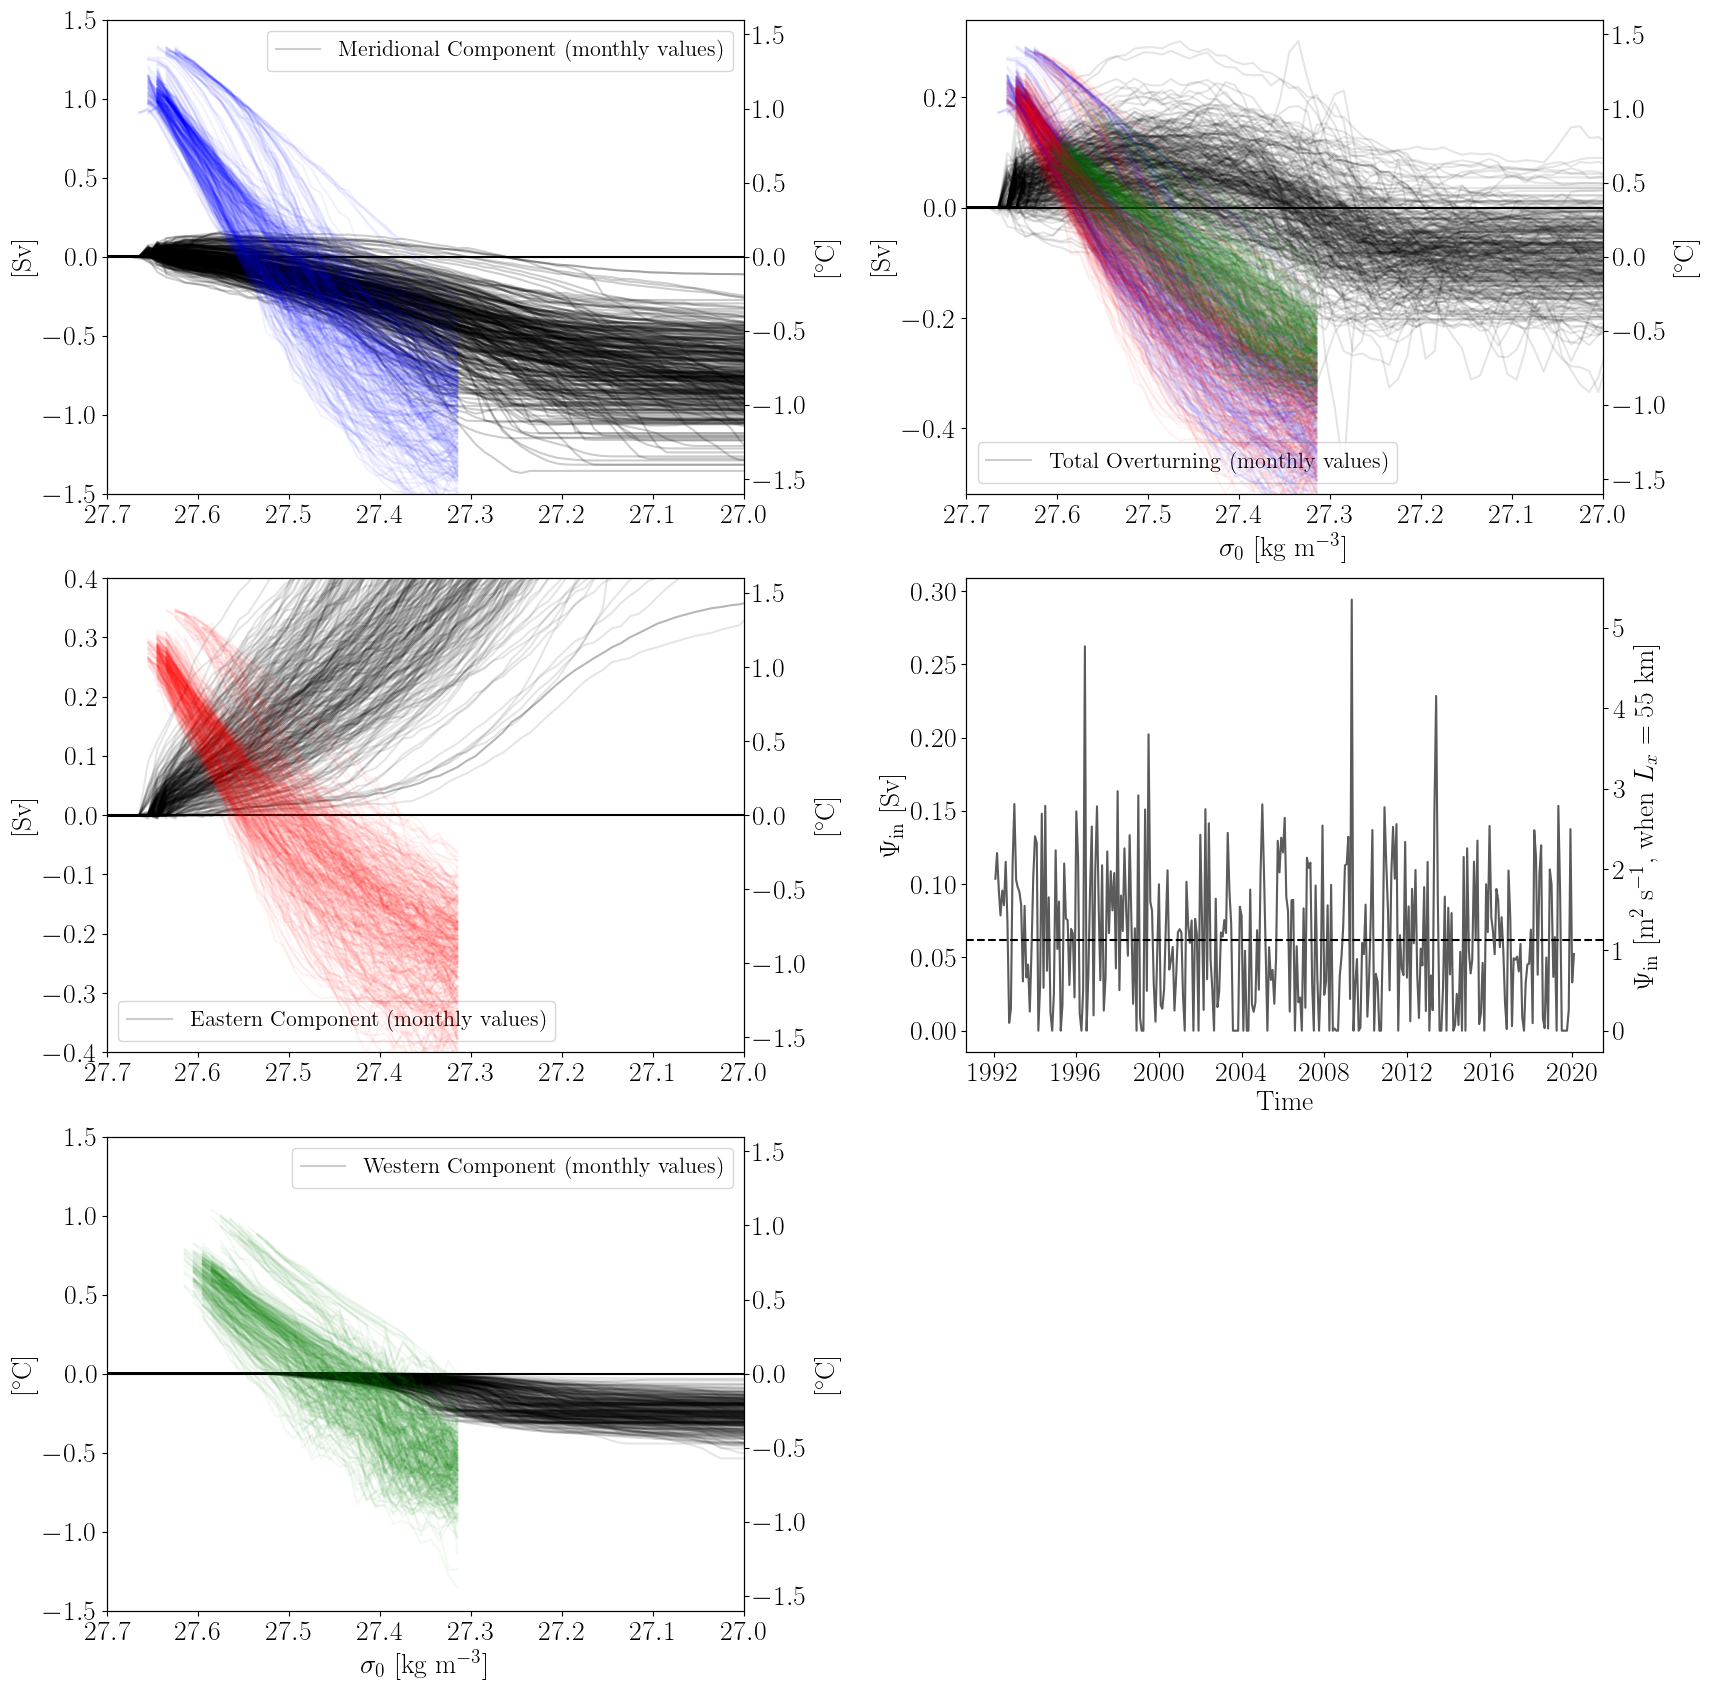

In [22]:
fig, ((ax, ax1),(ax2,ax3),(ax8,ax9)) = plt.subplots(3,2, figsize=(17,17))
fig.delaxes(ax9)

ax.plot(Ψin_northern.σ0_bin_center,Ψin_northern.T, 'k', alpha=0.2)
ax.plot(Ψin_northern.σ0_bin_center,Ψin_northern[0,:].T, 'k', alpha=0.2, label='Meridional Component (monthly values)'); ax.legend(loc=0, fontsize=16)
ax.set_xlim([27.7,27]);ax.set_ylim([-1.5,1.5])
ax5=ax.twinx()
ax5.plot(T_northern.σ0_bin_center[:50],T_northern.T[:50], 'b', alpha=0.05);
ax5.set_xlim([27.7,27]);ax5.set_ylim([-1.6,1.6])
ax.axhline(0,color='k')

ax2.plot(Ψin_eastern.σ0_bin_center,Ψin_eastern.T, 'k', alpha=0.1);
ax2.plot(Ψin_eastern.σ0_bin_center,Ψin_eastern[0,:].T, 'k', alpha=0.2, label='Eastern Component (monthly values)'); ax2.legend(loc=0, fontsize=16)
ax2.set_xlim([27.7,27]);ax2.set_ylim([-1.5,1.5])
ax6=ax2.twinx()
ax6.plot(T_eastern.σ0_bin_center[:50],T_eastern.T[:50], 'r', alpha=0.05);
ax6.set_xlim([27.7,27]);ax6.set_ylim([-1.6,1.6])
ax2.axhline(0,color='k')


ax8.plot(Ψin_western.σ0_bin_center,Ψin_western.T, 'k', alpha=0.1);
ax8.plot(Ψin_western.σ0_bin_center,Ψin_western[0,:].T, 'k', alpha=0.2, label='Western Component (monthly values)'); ax8.legend(loc=0, fontsize=16)
ax8.set_xlim([27.7,27]);ax8.set_ylim([-1.5,1.5])
ax10=ax8.twinx()
ax10.plot(T_western.σ0_bin_center[:50],T_western.T[:50], 'g', alpha=0.05);
ax10.set_xlim([27.7,27]);ax10.set_ylim([-1.6,1.6])
ax8.axhline(0,color='k')


ax1.plot(Ψin_total.σ0_bin_center,Ψin_total.T, 'k', alpha=0.1);
ax1.plot(Ψin_total.σ0_bin_center,Ψin_total[0,:].T, 'k', alpha=0.2, label='Total Overturning (monthly values)'); ax1.legend(loc=0, fontsize=16)
ax1.set_xlim([27.7,27]);ax2.set_ylim([-0.4,0.4])
ax7=ax1.twinx()
ax7.plot(T_northern.σ0_bin_center[:50],T_northern.T[:50], 'b', alpha=0.05);
ax7.plot(T_eastern.σ0_bin_center[:50],T_eastern.T[:50], 'r', alpha=0.05);
ax7.plot(T_western.σ0_bin_center[:50],T_western.T[:50], 'g', alpha=0.05);
ax7.set_xlim([27.7,27]);ax7.set_ylim([-1.6,1.6])
ax1.axhline(0,color='k')


ax3.plot(Ψin_mCDW.time,Ψin_mCDW, 'k', alpha=0.6)
ax3.axhline(Ψin_mCDW.mean('time'), color='k', linestyle='dashed'); 
# convert to m2/s units of Psiin
ax4=ax3.twinx()
translation = 1e6/(55*1e3)
ax4.plot(Ψin_mCDW.time,Ψin_mCDW*translation, 'k', alpha=0.1, label=r'monthly')



ax8.set_xlabel(r'$\sigma_0$ [kg m$^{-3}$]')
ax1.set_xlabel(r'$\sigma_0$ [kg m$^{-3}$]')
ax2.set_ylabel(r'[Sv]')
ax5.set_ylabel(r'[$^\circ$C]')
ax8.set_ylabel(r'[$^\circ$C]')
ax7.set_ylabel(r'[$^\circ$C]')
ax6.set_ylabel(r'[$^\circ$C]')
ax10.set_ylabel(r'[$^\circ$C]')
ax.set_ylabel(r'[Sv]')
ax1.set_ylabel(r'[Sv]')
ax3.set_ylabel(r'$\Psi_\mathrm{in}$ [Sv]')
ax4.set_ylabel(r'$\Psi_\mathrm{in}$ [m$^2$ s$^{-1}$, when $L_x=55$ km]')
ax3.set_xlabel(r'Time')
fig.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [23]:
Ψin_mCDW_climatology = Ψin_mCDW.groupby('time.month').mean()
Ψin_mCDW_climatology_expanded = xr.zeros_like(Ψin_mCDW)
for i in range(len(Fsurf_timeseries)):
    month = Ψin_mCDW['time.month'][i].values
    Ψin_mCDW_climatology_expanded[i] = Ψin_mCDW_climatology.sel(month=month)

In [24]:
rc('xtick', labelsize=29) 
rc('ytick', labelsize=29) 
rc('axes', labelsize=29)

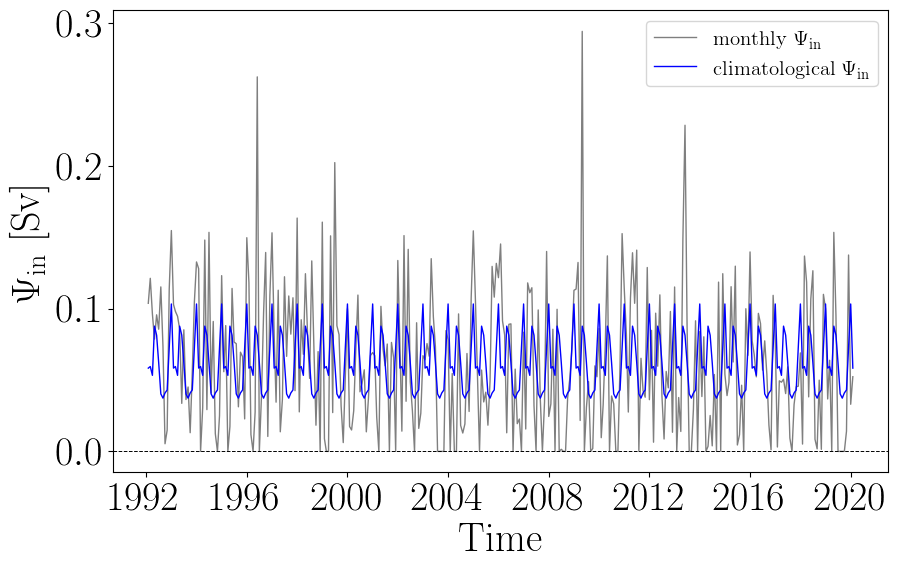

In [25]:
fig = plt.figure(figsize = (10,6))
ax = plt.subplot()
ax.plot(Ψin_mCDW.time,Ψin_mCDW, color='k', linewidth=1, alpha=0.5,label='monthly $\Psi_\mathrm{in}$')
ax.plot(Ψin_mCDW_climatology_expanded.time,Ψin_mCDW_climatology_expanded, color='b', linewidth=1,label='climatological $\Psi_\mathrm{in}$')
ax.set_xlabel('Time')
ax.axhline(0, color='k',linestyle='dashed',linewidth=0.7)
ax.set_ylabel(r'$\Psi_\mathrm{in}$ [Sv]')
ax.legend(loc=0, fontsize=15)
# plt.savefig('Figure_S2-3.png', bbox_inches='tight')

plt.show()

Now I want to plot the time mean overturning as a demonstration of the baroclinic circulaiton we're representing with our idealized model

In [26]:
diff = np.diff(Ψin_total,axis=1)
diff = xr.DataArray(np.append(np.zeros((337,1)),diff, axis=1), coords = [Ψin_total.time,Ψin_total.σ0_bin_center], dims=['time', 'σ0_bin_center'])
Ψin_masked = Ψin_total.where(diff!=0)

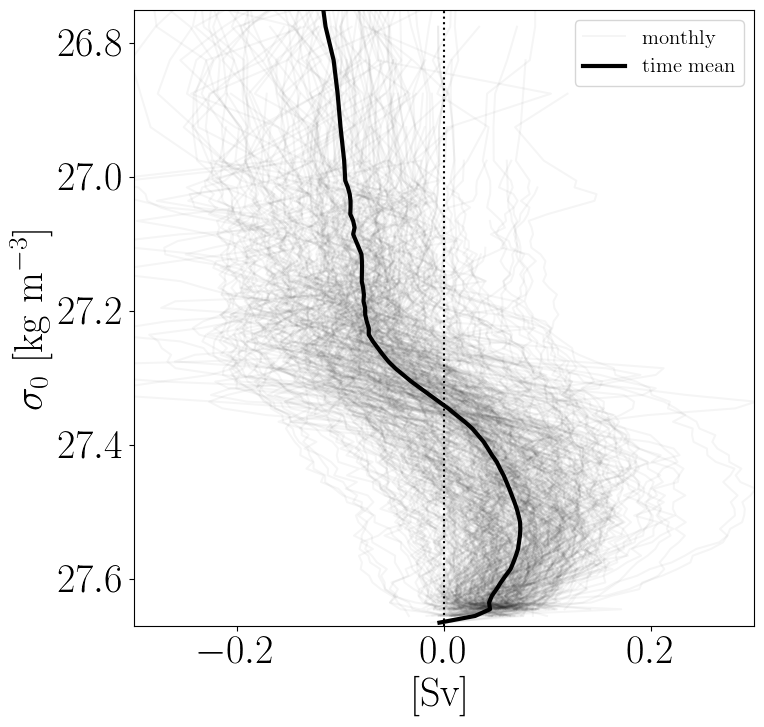

In [27]:
fig = plt.figure(figsize = (8,8))
ax = plt.subplot()
ax.plot(Ψin_masked.T, Ψin_masked.σ0_bin_center,'k', alpha=0.04);
ax.plot(Ψin_masked[0,:].T, Ψin_masked.σ0_bin_center[:],'k', alpha=0.04, label='monthly');
ax.plot(Ψin_masked.mean('time').T, Ψin_masked.σ0_bin_center,'k', linewidth=3, label='time mean');
ax.axvline(0,color='k', linestyle=':')
ax.set_ylabel(r'$\sigma_0$ [kg m$^{-3}$]')
ax.set_xlabel(r'[Sv]')
ax.invert_yaxis()
ax.set_ylim([27.67,26.75])
ax.set_xlim([-0.3,0.3])
ax.legend(loc=0, fontsize=15)
# plt.savefig('Figure_S2-4.png', bbox_inches='tight')
 
plt.show()

In [28]:
ds = xr.Dataset({ 'Fsurf':Fsurf_timeseries,  'Psiin':Ψin_mCDW})

In [29]:
ds.to_netcdf('WAIS1080_forcings.nc')

### map for supplementary material

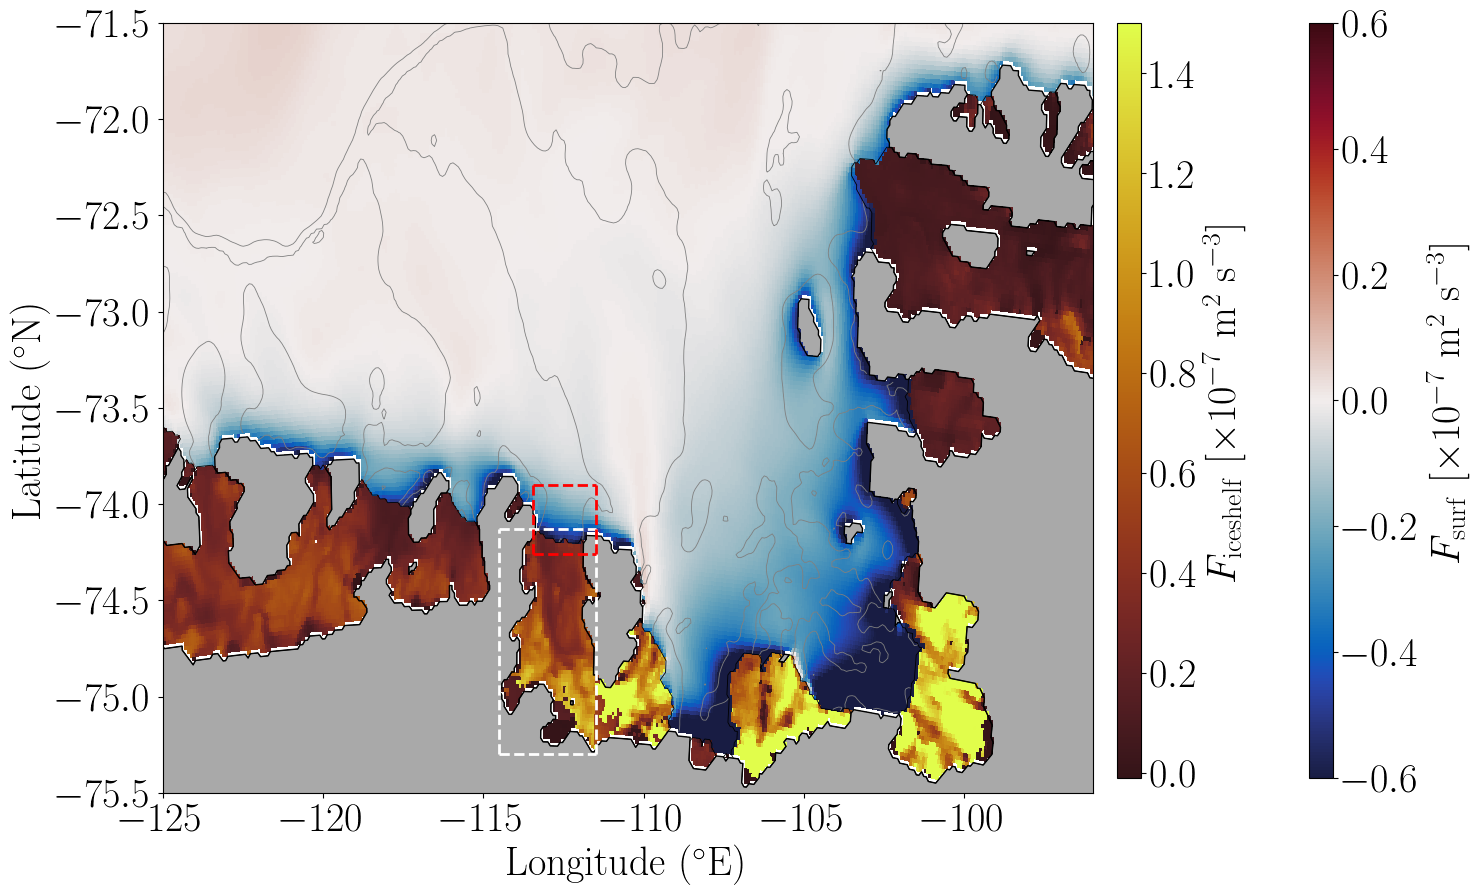

In [30]:
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
model_grid_map_features(ax, Fsurf_timemean)
c = ax.pcolormesh(Ficeshelf_timemean.LONC, Ficeshelf_timemean.LATC,Ficeshelf_timemean*1e7, cmap = cm.solar, vmax=1.5)
c2 = ax.pcolormesh(Fsurf_timemean.LONC, Fsurf_timemean.LATC,Fsurf_timemean*1e7, cmap = cm.balance, vmin=-0.6,vmax=0.6)

cax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c,cax = cax,orientation='vertical')
cbar.set_label(r'$F_\mathrm{ice shelf}$ [$\times 10^{-7}$ m$^{2}$ s$^{-3}$]')

cax = fig.add_axes([1.08, 0.125, 0.02, 0.755])
cbar=plt.colorbar(c2,cax = cax,orientation='vertical')
cbar.set_label(r'$F_\mathrm{surf}$ [$\times 10^{-7}$ m$^{2}$ s$^{-3}$]')


W=-114.5;E=-111.5;S=-75.3;N=-74.13
box(ax,W,E,S,N,'w')
W=-113.45;E=-111.5;S=-74.26;N=-73.9
box(ax,W,E,S,N,'r');
ax.set_xlim([-125,-96])
ax.set_ylim([-75.5,-71.5])
# fig.tight_layout()
# fig.savefig('Figure_S2-1.png',bbox_inches = "tight")

plt.show()